In [1]:
import pandas as pd
import numpy as np
import random

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
X  = pd.read_csv("tornado-xtrain.csv")
xCols = X.columns
X = pd.DataFrame(preprocessing.scale(X))
X.columns = xCols
y = pd.read_csv("tornado-ytrain.csv", header=None, index_col=0)

# from feature importances as determined by decision tree
"""unimportantFeatures = ["EVENT_ID", "median_income", "population_density", "weekend", "average_range", "average_latitude", "average_longitude", "percent_land", "multi_vortex"]
X = X.drop(columns=unimportantFeatures)"""
X

/home/zaned/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


,EVENT_ID,median_income,population_density,housing_units_density,duration,weekend,sin_time,cos_time,sin_date,cos_date,tornado_intensity,tornado_area,average_range,minimum_range,average_latitude,average_longitude,percent_land,multi_vortex
0,-0.659569,1.098649,0.012169,-0.005170,-0.368472,-0.590965,-0.817780,0.075304,-0.530114,2.118623,-0.392406,-0.258449,-0.629740,-0.506841,-1.072970,0.235116,-0.023330,-0.071174
1,0.790458,0.428080,3.270950,3.242428,-0.368472,1.692148,1.606678,1.698298,0.446904,-0.749221,-0.392406,-0.233282,-0.493229,-0.506841,-0.899881,-0.615041,-0.060532,-0.071174
2,-1.431252,0.487838,-0.201964,-0.214536,-0.658824,1.692148,-0.763944,-0.218737,-1.027300,-1.008074,-0.392406,-0.269888,-0.356718,-0.231217,1.217137,-0.282695,0.411083,-0.071174
3,0.470828,3.065708,0.095714,0.109644,0.647761,-0.590965,-0.781959,-0.149646,1.048617,0.687161,-0.392406,-0.251585,0.189327,0.320031,0.329424,-3.656563,-0.328900,-0.071174
4,-1.333534,0.721748,-0.196180,-0.210999,0.792938,-0.590965,0.420625,1.766379,-0.007042,-0.999205,2.548380,0.347831,0.325838,0.320031,0.490067,-0.499896,0.398010,-0.071174
5,0.933694,3.497331,0.972811,0.911413,0.067057,1.692148,-0.726011,0.740710,-0.666618,2.112686,-0.392406,0.004654,-0.356718,-0.231217,-0.841492,-0.552762,-0.174891,-0.071174
6,-0.943042,-0.978364,-0.176258,-0.185270,0.647761,-0.590965,-0.416724,-0.844721,-1.290301,1.922912,2.548380,0.032108,2.373505,1.973774,-1.186515,1.208485,0.309809,-0.071174
7,-1.501964,-1.024805,-0.186284,-0.201029,1.228466,-0.590965,-0.795412,0.493317,0.510217,-0.696602,-0.392406,1.102822,-0.356718,-0.506841,-0.876804,1.216327,0.316014,-0.071174
8,-1.422917,0.667027,-0.175358,-0.188808,5.728926,1.692148,-0.773353,-0.184284,0.403238,-0.782436,2.548380,5.367372,-0.356718,-0.231217,1.131348,0.015214,0.386906,-0.071174
9,0.346118,-0.941912,-0.186412,-0.187200,-0.078119,-0.590965,2.142336,-0.949581,-1.429987,1.836254,-0.392406,-0.247009,-0.493229,-0.506841,-1.488670,0.838709,-2.600630,-0.071174


## KNN

In [3]:
knn = KNeighborsClassifier()

## RNN

In [4]:
rnn = RadiusNeighborsClassifier(outlier_label=0)

## Cross Validation Functions

In [5]:
def testClassifier(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    #cm_normalized = [cm[i]/sum(cm[i]) for i in range(len(cm))]
    f1 = f1_score(y, y_pred, average = 'macro')
    
    return cm, f1

In [6]:
def crossValidate(clf):
    kf = KFold(n_splits=10)
    cms = []
    f1s = []
    for train_fold, test_fold in kf.split(X):
        
        sm = SMOTE(sampling_strategy='not majority')
        X_train_balanced, y_train_balanced = sm.fit_resample(X.iloc[train_fold], y.iloc[train_fold].values.ravel())
    
        clf.fit(X_train_balanced, y_train_balanced.ravel())
        cm, f1 = testClassifier(clf, X.iloc[test_fold], y.iloc[test_fold])
        cms.append(cm)
        f1s.append(f1)
    
    return sum(cms), np.mean(f1)

## Testing Defaults

In [7]:
for c in [knn, rnn]:
    print(crossValidate(c))
    print()

(array([[8918, 1761,  126],
       [ 305,  380,  109],
       [   5,   58,   44]]), 0.4207286782256794)

(array([[10106,   675,    24],
       [  672,    98,    24],
       [   81,    12,    14]]), 0.3611931119311193)



## KNN Hyperparameter Optimization

* n_neighbors
* metric

In [8]:
krange = range(1, 15)

In [9]:
"""for k in krange:
    print(k)
    for m in ["euclidean", "manhattan"]:
        knn = KNeighborsClassifier(n_neighbors=k, metric=m)
        print(crossValidate(knn))"""

'for k in krange:\n    print(k)\n    for m in ["euclidean", "manhattan"]:\n        knn = KNeighborsClassifier(n_neighbors=k, metric=m)\n        print(crossValidate(knn))'

## RNN Hyperparameter Optimization

* radius
* metric

In [10]:
rrange = np.arange(1.0, 10.0, 0.5)

In [11]:
"""for r in rrange:
    print(r)
    for m in ["euclidean", "manhattan"]:
        rnn = RadiusNeighborsClassifier(outlier_label=0, radius=r, metric=m)
        print(crossValidate(rnn))"""

'for r in rrange:\n    print(r)\n    for m in ["euclidean", "manhattan"]:\n        rnn = RadiusNeighborsClassifier(outlier_label=0, radius=r, metric=m)\n        print(crossValidate(rnn))'

## Best Model: RNN with radius=6.5 and Euclidean Distance Metric

In [12]:
rnn = RadiusNeighborsClassifier(outlier_label=0, radius=6.5, metric="euclidean")
cm, f1 = crossValidate(rnn)
print(cm)
print(f1)

[[9968  700  137]
 [ 384  332   78]
 [   6   48   53]]
0.5496148756171481


In [13]:
cm = np.array([np.round(cm[i]/sum(cm[i]), 3) for i in range(len(cm))])
print(cm)

[[0.923 0.065 0.013]
 [0.484 0.418 0.098]
 [0.056 0.449 0.495]]


In [14]:
cm_df = pd.DataFrame(cm, index=["negligible", "moderate", "severe"], columns=["negligible", "moderate", "severe"])
cm_df

,negligible,moderate,severe
negligible,0.923,0.065,0.013
moderate,0.484,0.418,0.098
severe,0.056,0.449,0.495


Text(0.5, 7.5, 'Predicted')

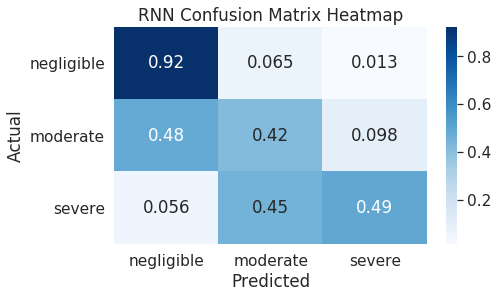

In [17]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1.4)
sns.heatmap(cm_df, annot=True, cmap = plt.cm.Blues)
plt.title("RNN Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")